In [1]:
#002 Making sure we have access to the right GPU for mixed precision training
#Mixed Precision Training
!nvidia-smi

Sat Feb 24 19:38:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.58                 Driver Version: 537.58       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P0              17W /  80W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from extras.helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir,compare_historys,make_confusion_matrix
import tensorflow as tf

In [3]:
#Use tensorflow datasets to download data
#pip uninstall tensorflow_datasets; pip install tensorflow_datasets==4.9.2
import tensorflow_datasets as tfds
dataset_list = tfds.list_builders()
print("food101" in dataset_list)

True


In [4]:
(train_data,test_data),ds_info = tfds.load(name="food101",
                                           split=["train","validation"],
                                           shuffle_files=True,
                                           as_supervised=True,
                                           with_info=True)

In [5]:
#005 Exploring and becoming one with the data (Food101 from TensorFlow Datasets)
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [6]:
len(ds_info.features["label"].names)

101

(512, 512, 3)
tf.Tensor(43, shape=(), dtype=int64)


(-0.5, 511.5, 511.5, -0.5)

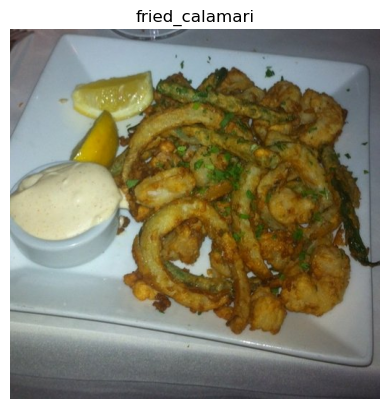

In [7]:
train_one_sample = train_data.take(1)
for image,label in train_one_sample:
    print(image.shape)
    print(label)

import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(ds_info.features["label"].names[label.numpy()])
plt.axis(False)

In [8]:
#006 Creating a preprocessing function to prepare our data for modelling
#EfiicientNetBx has rescaling built in
def preprocess_img(image,label,img_shape=224):
    image = tf.image.resize(image,[img_shape,img_shape])
    #image = image/255. not required for efficientnetBX
    return tf.cast(image,tf.float32),label


In [9]:
preprocessed_img = preprocess_img(image,label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[71 60 56]
  [70 59 55]
  [70 59 55]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]

 [[62 51 47]
  [64 53 49]
  [66 55 51]
  ...
  [65 60 67]
  [65 60 67]
  [64 59 66]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 65.81122   54.811222  50.811222]
  [ 73.331635  62.331635  58.331635]
  [104.015305  89.80102   86.80102 ]
  ...
  [ 61.85712   59.071384  65.64286 ]
  [ 65.        60.        67.      ]
  [ 64.64282   59.642822  66.64282 ]]

 [[ 67.28571   56.285717  52.285717]
  [ 66.47449   55.47449   51.47449 ]
  [ 67.73979   53.525505  50.525505]
  ...
  [ 64.14284   61.3571    67.92857 ]
  [ 65.93368   60.933674  67.93368 ]
  [ 64.285645  59.285645  66.285645]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


In [10]:
#007 Batching and preparing our datasets (to make them run fast)
#map preprocessing function to training
train_data = train_data.map(map_func=preprocess_img,num_parallel_calls = tf.data.AUTOTUNE)
#shuffle train data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data.map(map_func=preprocess_img,num_parallel_calls = tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)



In [11]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [12]:
#008 Exploring what happens when we batch and prefetch our data
#009 Creating modelling callbacks for our feature extraction model
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)


In [13]:
#011 Turning on mixed precision training with TensorFlow
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Laptop GPU, compute capability 8.6


In [14]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [15]:
#012 Creating a feature extraction model capable of using mixed precision training
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape = input_shape,name="input_layer")
x = base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)
x= layers.Dense(len(ds_info.features["label"].names))(x)
outputs = layers.Activation("softmax",dtype = tf.float32,name="softmax_float32")(x)
model = tf.keras.Model(inputs,outputs)


In [16]:
model.compile(loss="sparse_categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                             

In [18]:
#013 Checking to see if our model is using mixed precision training layer by layer
#check the dtype_policy attributes
for layer in model.layers:
    print(layer.name,layer.trainable,layer.dtype_policy)

input_layer True <Policy "float32">
efficientnetv2-b0 False <Policy "mixed_float16">
global_average_pooling2d True <Policy "mixed_float16">
dense True <Policy "mixed_float16">
softmax_float32 True <Policy "float32">


In [19]:
for layer in model.layers[1].layers[:20]:
    print(layer.name,layer.trainable,layer.dtype_policy)

input_1 False <Policy "float32">
rescaling False <Policy "mixed_float16">
normalization False <Policy "mixed_float16">
stem_conv False <Policy "mixed_float16">
stem_bn False <Policy "mixed_float16">
stem_activation False <Policy "mixed_float16">
block1a_project_conv False <Policy "mixed_float16">
block1a_project_bn False <Policy "mixed_float16">
block1a_project_activation False <Policy "mixed_float16">
block2a_expand_conv False <Policy "mixed_float16">
block2a_expand_bn False <Policy "mixed_float16">
block2a_expand_activation False <Policy "mixed_float16">
block2a_project_conv False <Policy "mixed_float16">
block2a_project_bn False <Policy "mixed_float16">
block2b_expand_conv False <Policy "mixed_float16">
block2b_expand_bn False <Policy "mixed_float16">
block2b_expand_activation False <Policy "mixed_float16">
block2b_project_conv False <Policy "mixed_float16">
block2b_project_bn False <Policy "mixed_float16">
block2b_drop False <Policy "mixed_float16">


In [20]:
#014 Training and evaluating a feature extraction model (Food Vision Big™)
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15*len(test_data)),
                                                     callbacks=[create_tensorboard_callback(dir_name="training_logs",
                                                                                            experiment_name="efficientnetv2b0_101_all_classes"),model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetv2b0_101_all_classes/20240224-193843
Epoch 1/3
2368/2368 [==============================] - 399s 165ms/step - loss: 1.7474 - accuracy: 0.5764 - val_loss: 1.1408 - val_accuracy: 0.6981
Epoch 2/3
2368/2368 [==============================] - 392s 165ms/step - loss: 1.2124 - accuracy: 0.6859 - val_loss: 1.0295 - val_accuracy: 0.7169
Epoch 3/3
2368/2368 [==============================] - 401s 169ms/step - loss: 1.0638 - accuracy: 0.7233 - val_loss: 0.9886 - val_accuracy: 0.7328
